# Using higher exited states of the computational resonator on IQM Star

In principle, the Deneb and Sirius QPU's computational resonator can be populated with more than one exitation. By default, this feature is disabled to ensure good calibration of gates and operations. However, there is an option to "unlock" the higher levels of the resonator to enable new research directions.

In this notebook, you will learn how to ...
* ... "unlock the resonator" with job settings
* ... populate the second excited state of the resonator 

In order to access IQM Deneb or IQM Sirius through IQM Resonance, you will need to create an API token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow your system's guidelines for creating an environment variable).

# Connecting to IQM Star

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance.

In [1]:
import os
import numpy as np
from iqm.pulla.pulla import Pulla
from iqm.qiskit_iqm import IQMProvider
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from iqm.qiskit_iqm import IQMCircuit
from qiskit import transpile
from iqm.qiskit_iqm import transpile_to_IQM
from iqm.iqm_client.transpile import ExistingMoveHandlingOptions
from iqm.iqm_client import CircuitCompilationOptions
from qiskit.visualization import plot_distribution
from qiskit.visualization import plot_distribution
from iqm.iqm_client import CircuitCompilationOptions
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from iqm.qiskit_iqm import IQMCircuit

token = os.getenv("IQM_TOKEN")
os.environ["IQM_TOKEN"] = token
server_url = "https://resonance.meetiqm.com/sirius"
p = Pulla(server_url)
backend = IQMProvider(server_url).get_backend()

/opt/miniconda3/envs/pulla-tutorial-oak/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/pulla-tutorial-oak/lib/python3.11/site-packages/iqm/iqm_server_client/iqm_server_client.py:150: UserWarning: The given IQM Server URL is in a deprecated format, see the client initialization instructions and correct URL format from the server web dashboard.
  warnings.warn(


# Prepare a circuit that excites the computational resonator multiple times

In order to bring the resonator to the first excited state, we can use the `X` gate on one of the connected qubits and swap the excitation from the qubit into the resonator via a <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> gate. In contrast to a conventional SWAP operation between two qubits, we leave the computational space by subsequently exciting the qubit and applying the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> gate. The reason for this behavior is the equidistant spacing of the energy levels of the computational resonator, which is a harmonic oscillator, as opposed to anharmonic qubits. It is a specific feature of this so-called Jaynes-Cummings interaction that the interaction strength between qubit and resonator eigenstate $|n\rangle$ increases with $\sqrt{n}$. As a result, applying the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> gate to the state $|1,e\rangle$, where both the qubit and the resonator are excited, implements the transformation:

$$|1,e\rangle \rightarrow \mathrm{cos} \left(\frac{\sqrt{2}\pi}{2}\right)\ket{1,e} -i\cdot\mathrm{sin}\left( \frac{\sqrt{2}\pi}{2}\right)\ket{2,g}$$

Note that without the $\sqrt{2}$ factor, this transformation would reproduce a swap of excitations, as desired by the MOVE gate for an unpopulated resonator. However, the increased coupling strength leads to an  "overrotation" in the swap operation, generating a superposition state as a result.
In this example, we will use Qiskit in combination with Qiskit-on-IQM to realize this type of interaction on the Sirius QPU.

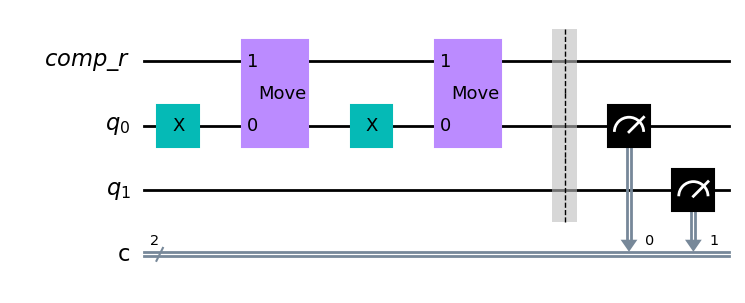

In [2]:
# Create Quantum Registers and Quantum Circuit
no_qubits = 2
comp_r = QuantumRegister(1, 'comp_r') # Computational resonator
q = QuantumRegister(no_qubits, 'q') # Qubits 
c = ClassicalRegister(2, 'c') # Classical register, used for readout
qc = IQMCircuit(comp_r, q, c)

qc.x(1)
qc.move(1,0) # MOVE first exitation into the resonator
qc.x(1)
qc.move(1,0) # MOVE second exitation into the resonator

qc.barrier()
qc.measure([1,2],[0,1])
qc.draw("mpl", style="clifford")

# Modify job settings and submit circuit

Let's just try to submit the above circuit now with standard settings:

In [3]:
shots = 5000

transpiled_qc = transpile_to_IQM(qc, backend=backend, existing_moves_handling=ExistingMoveHandlingOptions.KEEP)

job = backend.run(transpiled_qc, shots=shots)

CircuitTranspilationError: Instruction prx acts on ('QB1',) while the state(s) of {'QB1'} are in a resonator. Current resonator occupation: {'COMPR1': 'QB1'}.

We observe an error message that a <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">PRX</span> gate is not allowed while an exitation is in the computational resonator!

By default, it is not allowed to <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> a second excitation to the computation resonator. In order to do so, one needs to explicitly allow this with an optional argument during job submission. The relevant setting for this is `move_gate_validation` with options `strict`, `allow_prx`, and `none`. Let's try it again:

In [5]:
circuit_compilation_options=CircuitCompilationOptions(move_gate_validation='allow_prx')

[01-21 13:28:42;I] Waiting for job 019be087-4efd-7b33-b900-75562a966cc9 to finish...


Progress in queue:   0%|                                  | 0/1 [00:06<?, ?it/s]


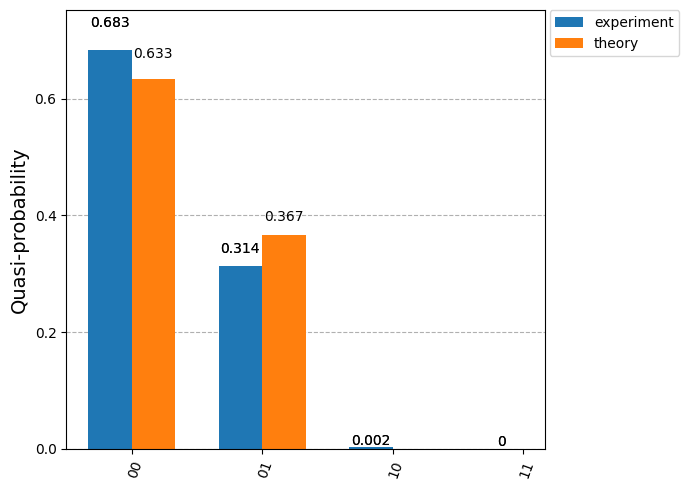

In [6]:
shots = 5000

transpiled_qc = transpile_to_IQM(qc, 
                                 backend=backend, 
                                 existing_moves_handling=ExistingMoveHandlingOptions.KEEP,
                                 perform_move_routing = False
                                 )

job = backend.run(transpiled_qc, shots=shots, circuit_compilation_options=circuit_compilation_options)

res = job.result()
counts = res.get_counts()

# Calculate ideal result
counts_ideal = {'00': np.sin(np.sqrt(2)*np.pi/2)**2, '01': np.cos(np.sqrt(2)*np.pi/2)**2, '10':0, '11':0}

plot_distribution([counts, counts_ideal], legend=['experiment', 'theory'])

In this case, we expect to measure probabilities for ground state population of $\sin^2 \left(\frac{\sqrt{2}\pi}{2}\right)$ and an excited state population of $\cos^2 \left(\frac{\sqrt{2}\pi}{2}\right)$, resulting from the "overrotation" due to the JC interaction.

# Investigate computational resonator population

In the previous experiment, we only looked at the remaining population in the qubit used for the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation. To obtain more information about the resonator population, we can apply a <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation with the second qubit and read it out

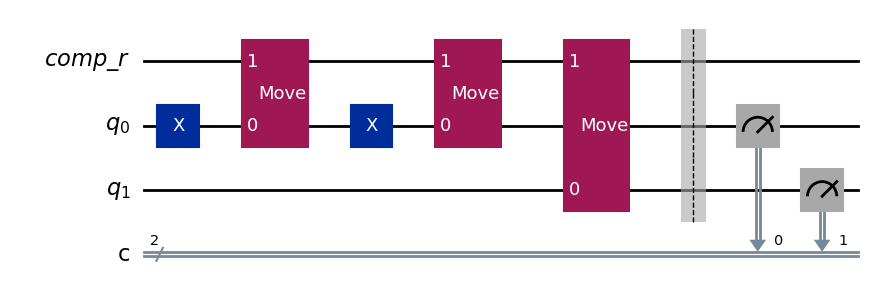

In [25]:
# Create Quantum Registers and Quantum Circuit
no_qubits = 2
comp_r = QuantumRegister(1, 'comp_r') # Computational resonator
q = QuantumRegister(no_qubits, 'q') # Qubits 
c = ClassicalRegister(2, 'c') # Classical register, used for readout
qc = IQMCircuit(comp_r, q, c)

qc.x(1)
qc.move(1,0) # MOVE first exitation into the resonator
qc.x(1)
qc.move(1,0) # MOVE second exitation into the resonator
qc.move(2,0) # MOVE second exitation into the resonator

qc.barrier()
qc.measure([1,2],[0,1])
qc.draw("mpl")

In order to be able to apply the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation to the second qubit, `move_gate_validation` must be set to `none`. Unfortunately, this mode does not allow to perform so called "frame tracking" which is needed to calculate required Z-rotations, which accumulate while exitations are in the resonator. We can deactivate frame tracking by setting `move_gate_frame_tracking` to `none`.

[01-20 19:17:18;I] Waiting for job 019bdca0-18de-7391-8ffc-d20870a01598 to finish...


Progress in queue:   0%|                                                                                     | 0/1 [00:05<?, ?it/s]


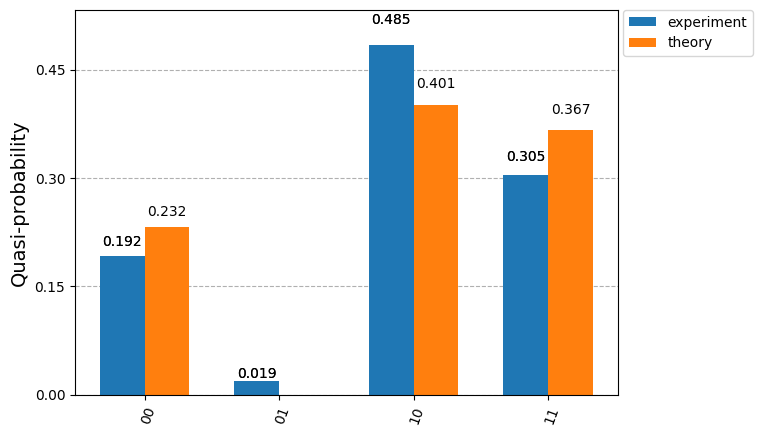

In [26]:
circuit_compilation_options=CircuitCompilationOptions(move_gate_validation='none', move_gate_frame_tracking='none')

shots = 5000

transpiled_qc = transpile_to_IQM(qc, 
                                 backend=backend, 
                                 existing_moves_handling=ExistingMoveHandlingOptions.KEEP,
                                 perform_move_routing = False
                                 )


job = backend.run(transpiled_qc, shots=shots, circuit_compilation_options=circuit_compilation_options)

res = job.result()
counts = res.get_counts()

# Calculate ideal result
counts_ideal = {'00': np.sin(np.sqrt(2)*np.pi/2)**2*np.cos(np.sqrt(2)*np.pi/2)**2, '01': 0, '10':(np.sin(np.sqrt(2)*np.pi/2)**2)**2, '11':np.cos(np.sqrt(2)*np.pi/2)**2}

plot_distribution([counts, counts_ideal], legend=['experiment', 'theory'])

In this case, we expect to measure probabilities for `00` of $\sin^2 \left(\frac{\sqrt{2}\pi}{2}\right)\cos^2 \left(\frac{\sqrt{2}\pi}{2}\right)$, `10` of $\sin^2 \left(\frac{\sqrt{2}\pi}{2}\right)^2$, and `11` of $\cos^2 \left(\frac{\sqrt{2}\pi}{2}\right)^2$.

And, indeed, the experimental verification of the above predictions is in good agreement with the theoretical expectations: The Jaynes-Cummings type interaction leads to an  "overrotation" during the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">MOVE</span> operation, potentially generating a superposition state as a result.

Having qubits combined with harmonic elements in the same quantum processor opens up new possibilities for quantum algorithms, and we are curious to see what you use it for.

In [1]:
# Copyright 2024 IQM Quantum Computers (Stefan Pogorzalek, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.